In [5]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import glob
import os
import math
import logomaker

os.chdir('/disk1/jyang4/repos/DKBO-MLDE/')
#import objectives
#import utils
from tqdm import tqdm
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
# %matplotlib notebook
import seaborn as sns

font = {'size'   : 12}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

ALL_AAS = ("A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y")

from scipy.stats import norm

def z_score_for_confidence_interval(confidence_level):
    # Ensure the confidence level is between 0 and 100
    if confidence_level <= 0 or confidence_level >= 1:
        raise ValueError("Confidence level must be between 0 and 1 (exclusive)")

    # Convert confidence level to a two-tailed probability
    p = 1 - (1 - confidence_level) / 2

    # Use the percent point function (ppf) of the standard normal distribution
    z_score = norm.ppf(p)

    return z_score

In [76]:
df = pd.read_csv('all_results.csv')
#repalce DNN with DNN_ENSEMBLE
#df = df[df['Model'] == 'DNN_ENSEMBLE']

In [77]:
#for every row, duplicate the row but change mean
df_lower = df.copy()
df_lower['Mean'] = df_lower['Mean'] - df_lower['Std']
df_upper = df.copy()
df_upper['Mean'] = df_upper['Mean'] + df_upper['Std']
df = pd.concat([df, df_lower, df_upper])
df = df.reset_index(drop=True)

/tmp/ipykernel_446127/3169271536.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random


/tmp/ipykernel_446127/3169271536.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_446127/3169271536.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_446127/3169271536.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_446127/3169271536.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random
/tmp/ipykernel_446127/3169271536.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random
/tmp/ipyke

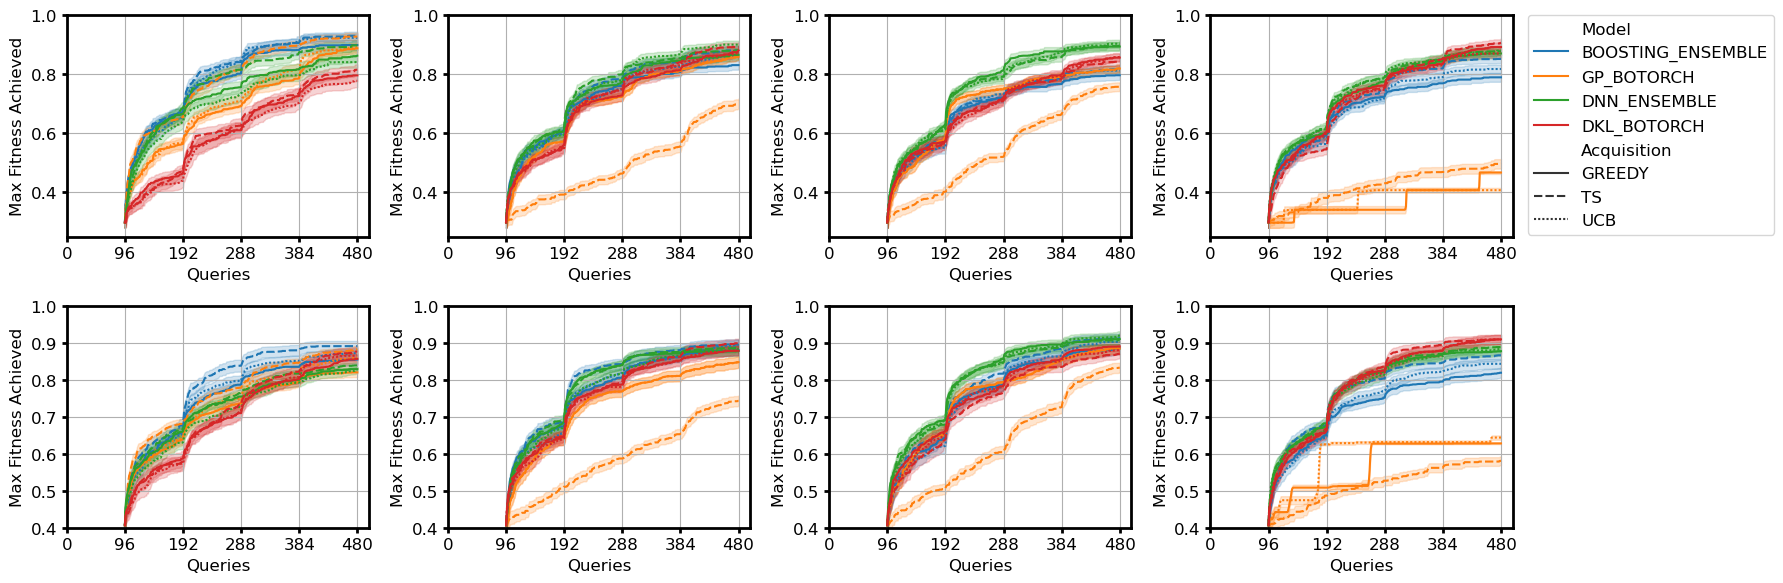

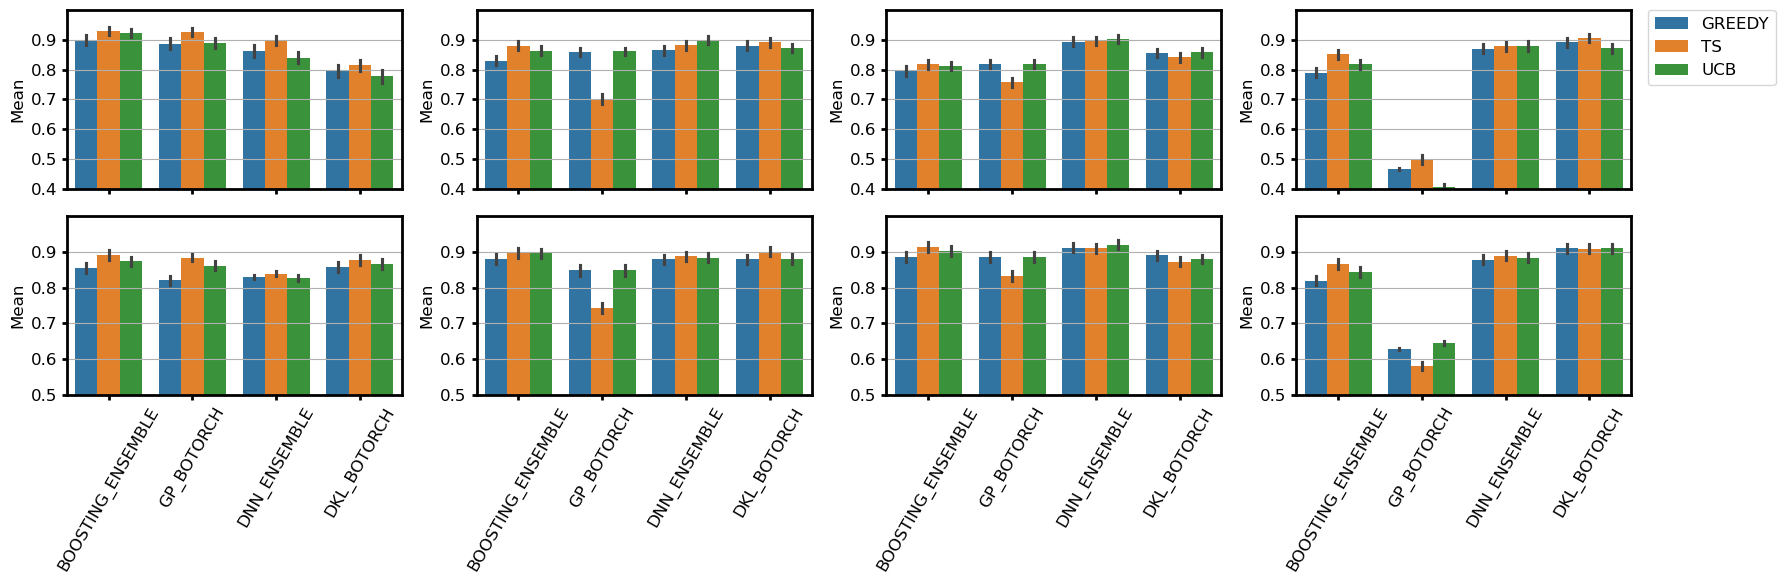

In [78]:
plt.figure(1, figsize=(18, 6))
plt.figure(2, figsize=(18, 6))
i = 0

order = ['BOOSTING_ENSEMBLE', 'GP_BOTORCH', 'DNN_ENSEMBLE', 'DKL_BOTORCH'] #'RANDOM'

for protein in ['GB1', 'TrpB']:
    for encoding in ['AA', 'georgiev', 'onehot', 'ESM2']:
    
        subset = df[df['Protein'] == protein][df['Encoding'].isin([encoding])] #'Random
        #subset df[df['Protein'] == 'GB1'][df['Encoding'] == 'Random']

        plt.figure(1)
        plt.subplot(2, 4, i + 1)
        #ax.fill_between(df.Timestep, df.Mean - df.STD, df.Mean + df.STD, alpha=0.2)
        if i == 3:
            sns.lineplot(data=subset, x="Timestep", y="Mean", hue='Model', style="Acquisition", hue_order= order, errorbar=('pi', 100))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        else: 
            sns.lineplot(data=subset, x="Timestep", y="Mean", hue='Model', style="Acquisition", hue_order= order, errorbar=('pi', 100), legend=False)

        plt.xticks(np.arange(0, 480 + 96, 96))
        if protein == 'GB1':
            plt.ylim([0.25, 1])
        else:
            plt.ylim([0.4, 1])
        plt.grid()
        plt.ylabel('Max Fitness Achieved')
        plt.xlabel('Queries')

        plt.figure(2)
        plt.subplot(2, 4, i + 1)
        last = subset[subset['Timestep'] == 480]
        dictionary = dict(zip(last['Mean'], last['Std']))
        
        def get_std(mean):
            return(0.8, 0.95)
            return (mean - dictionary[mean], mean + dictionary[mean])
        
        if i == 3:
            ax = sns.barplot(data=last, x='Model', y='Mean', hue='Acquisition', order= order, errorbar=('pi', 100))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        else:
            ax = sns.barplot(data=last, x='Model', y='Mean', hue='Acquisition', legend=False, order= order, errorbar=('pi', 100))
        
        if i <= 3: 
            ax.set_xticklabels([])

        ax.yaxis.grid(True)
        plt.xlabel('')
        if protein == 'GB1':
            plt.ylim([0.4, 1])
            plt.yticks(np.arange(0.4, 1, 0.1))
        else:
            plt.ylim([0.5, 1])
            plt.yticks(np.arange(0.5, 1, 0.1))

        plt.xticks(rotation=60) 

        i += 1


plt.figure(1)
plt.tight_layout()

plt.figure(2)
plt.tight_layout()

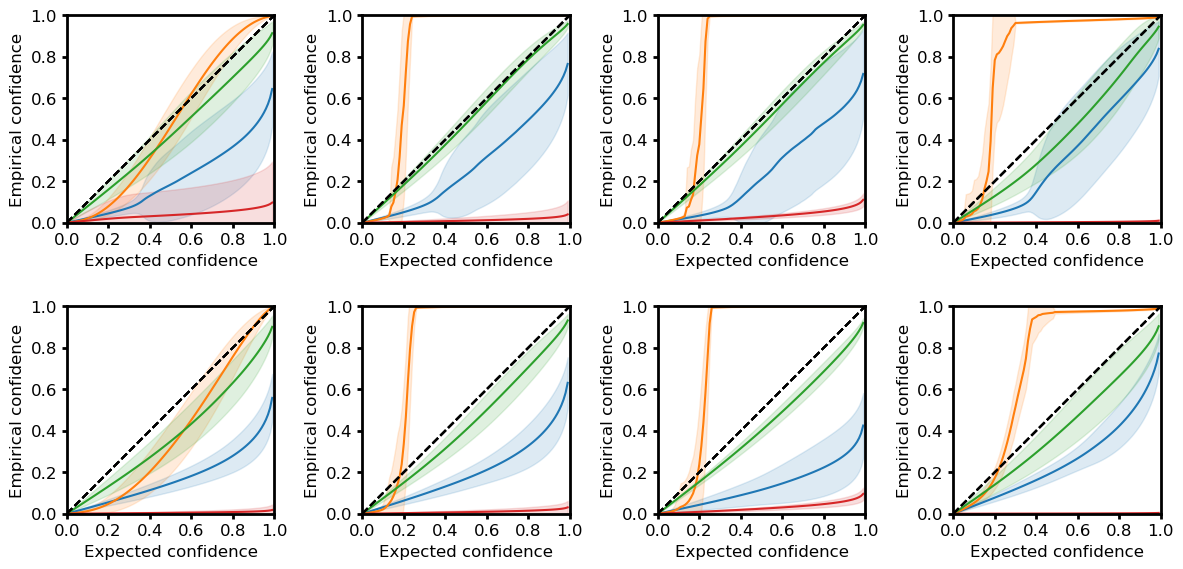

In [81]:
plt.figure(1, figsize=(12, 6))

j = 0

model_order = ['BOOSTING_ENSEMBLE', 'GP_BOTORCH', 'DNN-ES_ENSEMBLE', 'DKL_BOTORCH'] #'RANDOM'

dimension_dict1 = {'AA': '16', 'georgiev': '76', 'onehot': '80', 'ESM2': '5120'}
dimension_dict2 = {'AA': '8', 'georgiev': '30', 'onehot': '30', 'ESM2': '50'}

model_dict = {'BOOSTING_ENSEMBLE': 'Boosting', 'GP_BOTORCH': 'GP', 'DNN-ES_ENSEMBLE': 'DNN', 'DKL_BOTORCH': 'DKL', 'RANDOM': 'Random'}
for protein in ['GB1', 'TrpB']:
    if protein == 'GB1':
        fitness_df = pd.read_csv('/disk1/jyang4/repos/data/GB1_fitness.csv')
        fitness_col = 'fit'
    elif protein == 'TrpB':
        fitness_df = pd.read_csv('/disk1/jyang4/repos/data/TrpB_fitness.csv')
        fitness_col = 'fitness'

    for encoding in ['AA', 'georgiev', 'onehot', 'ESM2']:
        prefix = f'{protein}_{encoding}'
        
        plt.subplot(2, 4, j + 1)
        ax = plt.gca()
        ax.set_aspect('equal')

        j += 1

        for model in model_order:
            if model in ['GP_BOTORCH', 'BOOSTING_ENSEMBLE']:
                dimension = dimension_dict1[encoding]
            else:
                dimension = dimension_dict2[encoding]
            directory = f'{model}-DO-0-RBF-UCB-[{dimension}, 1]_'
            directory_prefix = f'/disk1/jyang4/repos/DKBO-MLDE/results/{prefix}/{directory}'

            n_repeats =70
            n_points= 99

            all_ys = np.zeros((n_points, n_repeats))
            for i in range(n_repeats):


                sigma = torch.load(directory_prefix + str(i+1) + 'sigma.pt')
                mu = torch.load(directory_prefix + str(i+1) + 'mu.pt')
                indices = torch.load(directory_prefix + str(i+1) + 'indices.pt')
            

                fitness_df[fitness_col] = fitness_df[fitness_col]/fitness_df[fitness_col].max()
                fitness_df['sigma'] = sigma
                fitness_df['mu'] = mu
                
                fitness_df['normalized_sigma'] = abs(sigma/mu)
                fitness_df['UCB'] = fitness_df['mu'] + 2 * fitness_df['sigma']
                fitness_df['LCB'] = fitness_df['mu'] - 2 * fitness_df['sigma']
                fitness_df['calibrated'] = (fitness_df[fitness_col] > fitness_df['LCB']) & (fitness_df[fitness_col] < fitness_df['UCB'])
                fitness_df['normalized_error'] = abs((fitness_df['mu'] - fitness_df[fitness_col])/fitness_df['mu'])
                fitness_df['error'] = abs((fitness_df['mu'] - fitness_df[fitness_col]))
                
                #print(fitness_df['calibrated'].sum()/len(fitness_df))

                #subset = fitness_df.iloc[indices[:96]]
                subset = fitness_df.iloc[indices[:384]]

                confidences = np.linspace(0.01, 0.99, n_points)
                y = []
                for confidence in confidences:
                    z_score = z_score_for_confidence_interval(confidence)
                    #fitness_df = nearby_df only check the similar variants
                    #fitness_df = subset
                    fitness_df['UCB_temp'] = fitness_df['mu'] + z_score * fitness_df['sigma']
                    fitness_df['LCB_temp'] = fitness_df['mu'] - z_score * fitness_df['sigma']
                    fitness_df['calibrated_temp'] = (fitness_df[fitness_col] > fitness_df['LCB_temp']) & (fitness_df[fitness_col] < fitness_df['UCB_temp'])
                    y.append(fitness_df['calibrated_temp'].sum()/len(fitness_df))
                
                all_ys[:, i] = y
                
                # old_combos = subset['Combo']
                # #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
                # new_combos = fitness_df.iloc[indices[384:]]['Combo']
                # min_distances = []
                # min_distances_args = []
                # for combo1 in new_combos:
                #     distances = []
                #     for combo2 in old_combos:
                #         distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
                #     min_distances.append(min(distances))
                #     min_distances_args.append(np.argmin(distances))
                
                # unique_indces, counts = np.unique(min_distances_args, return_counts=True)
                # #new_subset = subset.iloc[unique_indces]
                # #new_subset['count'] = counts

                # # histogram of the minimum distances
                # # plt.subplot(2, 5, i+1)
                # # plt.hist(min_distances)

                # nearby_variants = []
                # #for combo in subset['Combo']:
                # ordered_subset = subset.sort_values(fitness_col, ascending=False)
                # for combo in ordered_subset['Combo'][:]:
                #     for site in range(4):
                #         for aa in ALL_AAS:
                #             variant = combo[:site] + aa + combo[site+1:]
                #             nearby_variants.append(variant)
                # #drop duplicates in nearby_variants
                # nearby_variants = list(set(nearby_variants))
                # #print(len(nearby_variants))

                # #to filter to only nearby variants
                # nearby_df = fitness_df[fitness_df['Combo'].isin(nearby_variants)]
                # nearby_indices = nearby_df.index
                # #print(nearby_df['calibrated'].sum()/len(nearby_df))

                # top_nearby_df = nearby_df.sort_values(fitness_col, ascending=False)[:96]
                # #print(top_nearby_df['calibrated'].sum()/len(top_nearby_df))
                # #print('\n')

                # #get rid of outliers
                # #print(len(fitness_df))
                
                # fitness_df.sort_values(fitness_col, ascending=True, inplace=True)

            mean = all_ys.mean(axis=1)
            p = plt.plot(confidences, mean, '-')
            sem = all_ys.std(axis=1)
            plt.fill_between(confidences, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
            plt.plot([0,1], [0,1], '--k')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.xticks(np.arange(0, 1.1, 0.2))
            plt.yticks(np.arange(0, 1.1, 0.2))
            plt.xlabel('Expected confidence')
            plt.ylabel('Empirical confidence')
            
        
        # if j == 3:
        #     plt.legend(model_order, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.tight_layout()

### Check the log likelihood during training and compare between models
What are reasonable values for this number?

In [2]:
#can check this by watching the terminal
#was indeed lower negative log likelihood for the DK compared to GP


### Analyze the distribution of sequences
Could also make this plot with the letters how it's often seen
5site libraries

In [9]:
def plot_logo(batch, acquisition):
  dfs = []
  for i in range(1, 6):
      temp = batch.groupby(f'AA{i}').count()
      temp[i] = temp.mean(axis=1)
      temp = temp[[i]]
      temp.index.name = ''
      temp = temp.copy().T
      dfs.append(temp)
  
  df = pd.concat(dfs)
  #replace nan with 0
  df = df.fillna(0)
  #normalize rows to 1
  df = df.div(df.sum(axis=1), axis=0)
  df

  # create Logo object
  AAs_logo = logomaker.Logo(df,
                            color_scheme='weblogo_protein',
                            #font_name='Arial',
                            vpad=.15,
                            figsize=(3, 2.5),
                          #   baseline_width=.8,
  )

  # additional styling using Logo methods
  AAs_logo.style_spines(visible=False)

  # style using Axes methods
  AAs_logo.ax.set_ylim([0, 1])
  AAs_logo.ax.set_ylabel('frequency', labelpad=0)
  AAs_logo.ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
  AAs_logo.ax.set_xticks([1,2,3,4, 5])
  AAs_logo.ax.set_title(acquisition)

  return

/tmp/ipykernel_13312/2226491384.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_13312/2226491384.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])
/tmp/ipykernel_13312/2226491384.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

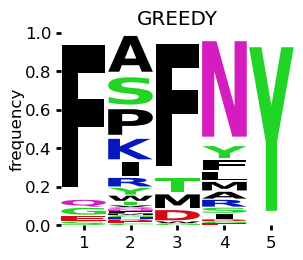

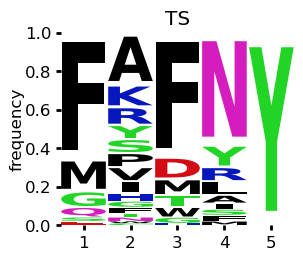

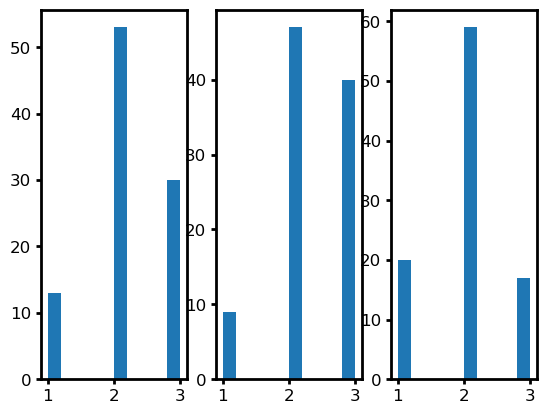

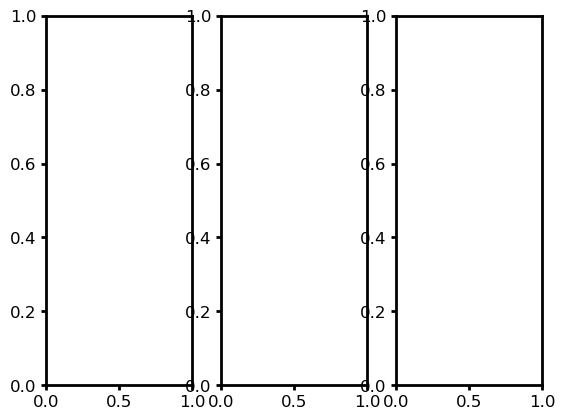

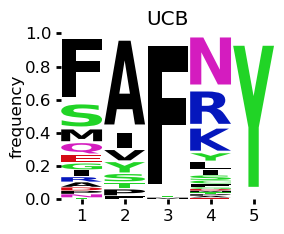

In [35]:
#just to get a mapping from indices to combos
fitness_df = pd.DataFrame()
combos = np.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/combos.npy')
fitness_df['Combo'] = combos
fitness_df

#plt.figure(figsize=(20, 9))
counter = 0
for i in [1]:
    for acq in  ['GREEDY', 'TS', 'UCB']:

        # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_1indices.pt')
        indices= torch.load(f'/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DNN_ENSEMBLE-DO-0-RBF-{acq}-[30, 1]_1indices.pt')
        # indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/production_test/GP_BOTORCH-DO-0-RBF-UCB-[100, 1]_1indices.pt')

            
        subset = fitness_df.iloc[indices, :].reset_index()
        batch = subset[-96:] #look at the most recent 96

        old_combos = subset[:-96]['Combo']
        #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
        new_combos = batch['Combo']
        min_distances = []
        min_distances_args = []
        for combo1 in new_combos:
            distances = []
            for combo2 in old_combos:
                distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
            min_distances.append(min(distances))
            min_distances_args.append(np.argmin(distances))
        plt.figure(1)
        plt.subplot(1, 3, counter +1)
        plt.hist(min_distances)

        for l in range(5):
            batch['AA' + str(l+1)] = batch['Combo'].apply(lambda x: x[l])

        # for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4', 'AA5']):

        #     plt.subplot(3, 5, counter+1)
        #     counter += 1
        #     batch[label].value_counts().plot(kind="bar")
        #     #sns.countplot(x=label, data=batch)

        plt.figure(2)
        plt.subplot(1, 3, counter +1)
        plot_logo(batch, acq)

        counter += 1
    plt.tight_layout()

In [36]:
batch.head(20)

,index,Combo,AA1,AA2,AA3,AA4,AA5
216,641899,FAFRY,F,A,F,R,Y
217,641779,FAFKY,F,A,F,K,Y
218,641839,FAFNY,F,A,F,N,Y
219,2401839,SAFNY,S,A,F,N,Y
220,697839,FIFNY,F,I,F,N,Y
221,2081839,QAFNY,Q,A,F,N,Y
222,641919,FAFSY,F,A,F,S,Y
223,2081899,QAFRY,Q,A,F,R,Y
224,697899,FIFRY,F,I,F,R,Y
225,2401779,SAFKY,S,A,F,K,Y


In [18]:
sigma = torch.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DNN_ENSEMBLE-DO-0-RBF-UCB-[30, 1]_1sigma.pt')
mu = torch.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DNN_ENSEMBLE-DO-0-RBF-UCB-[30, 1]_1mu.pt')
indices= torch.load(f'/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DNN_ENSEMBLE-DO-0-RBF-UCB-[30, 1]_1indices.pt').tolist()
sigma

tensor([0.1254, 0.1929, 0.1919,  ..., 0.0666, 0.1077, 0.0980],
       dtype=torch.float64)

In [24]:
df = pd.DataFrame({'sigma': sigma[indices], 'mu': mu[indices]})
df

,sigma,mu
0,0.002844,0.846352
1,0.298786,0.694166
2,0.005551,0.596900
3,0.010182,0.572400
4,0.082900,0.407637
...,...,...
307,0.208960,0.660188
308,0.192838,0.692257
309,0.166547,0.744738
310,0.291649,0.494148


In [26]:
#add a column with last 96 rows being 'test'
df['train_test'] = 'train'
df.loc[312-96:, 'train_test'] = 'test'
df

,sigma,mu,train_test
0,0.002844,0.846352,train
1,0.298786,0.694166,train
2,0.005551,0.596900,train
3,0.010182,0.572400,train
4,0.082900,0.407637,train
...,...,...,...
307,0.208960,0.660188,test
308,0.192838,0.692257,test
309,0.166547,0.744738,test
310,0.291649,0.494148,test


Text(33.222222222222214, 0.5, 'sigma')

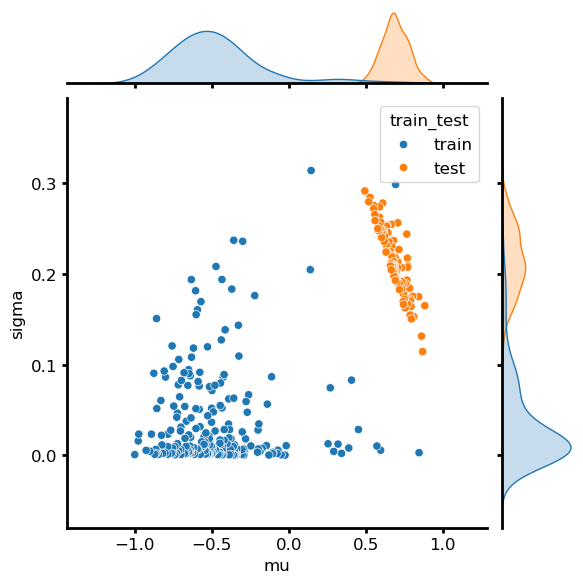

In [27]:
sns.jointplot(x='mu', y='sigma', data=df, hue='train_test')
plt.xlabel('mu')
plt.ylabel('sigma')

In [7]:
# subdir = '/disk1/jyang4/repos/DKBO-MLDE/results/GB1_onehot'
# tensors = sorted(glob.glob(subdir + '/*indices*.pt'))

#fitness_df = pd.read_csv('/disk1/jyang4/repos/data/GB1_fitness.csv')
#fitness_df = pd.read_csv('/disk1/jyang4/repos/data/TrpB_fitness.csv')

plt.figure(figsize=(16, 6))
for i in [0]:
    for j, acq in enumerate(['GREEDY', 'TS', 'UCB']):
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/ensembles/GB1_ESM2/DNN-ES_ENSEMBLE-DO-0-RBF-%s-[150, 1]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/ensembles/GB1_AA/BOOSTING_ENSEMBLE-DO-0-RBF-%s-[16, 1]_%dindices.pt' % (acq, i+1))
        indices = torch.load('/disk1/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DNN-ES_ENSEMBLE-DO-0-RBF-%s-[30, 1]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-%s-[10, 10]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/disk1/jyang4/repos/DKBO-MLDE/results/GB1_AA/GP_BOTORCH-DO-0-RBF-%s-[16, 1]_%dindices.pt' % (acq, i+1))
        #indices = torch.load('/home/jyang4/repos/DKBO-MLDE/results/TrpB_onehot/CDKL-DO-0-RBF-%s-[32, 32]_%dindices.pt' % (acq, i+1))
        indices = f'/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DNN_ENSEMBLE-DO-0-RBF-{acq}-[30, 1]_1indices.pt'

        subset = fitness_df.iloc[indices, :].reset_index()

        n = 1 #first batch after the random initialization
        batch = subset[96*n:96*(n+1)]

        plot_logo(batch, acq)
        # for k, label  in enumerate(['AA1', 'AA2', 'AA3', 'AA4']):
        #     plt.subplot(3, 4, 4*j + k+1)
        #     batch[label].value_counts().plot(kind="bar")
        #     #sns.countplot(x=label, data=batch)
    plt.tight_layout()

NameError: name 'fitness_df' is not defined

<Figure size 1600x600 with 0 Axes>

### TODO: Embed all possible sequences in pca, umap, or tsne, and then plot

In [1]:
from src.encoding_utils import *

In [2]:
combos = np.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/combos.npy')
embeddings = generate_onehot(combos) # onehot, DKL, TS
#embeddings = torch.load('/home/jyang4/repos/data/trpB_onehot_x.pt')
#fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')
#embeddings = embeddings.detach().numpy()
embeddings.shape

torch.Size([3200000, 5, 20])

In [3]:
embeddings = embeddings.reshape(embeddings.shape[0], -1)

NameError: name 'indices' is not defined

<Figure size 1200x800 with 0 Axes>

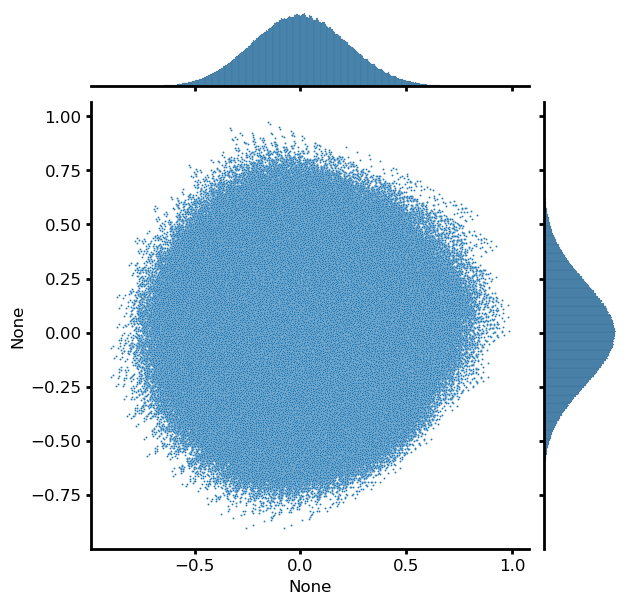

In [6]:
#PCA transform on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1200x800 with 0 Axes>

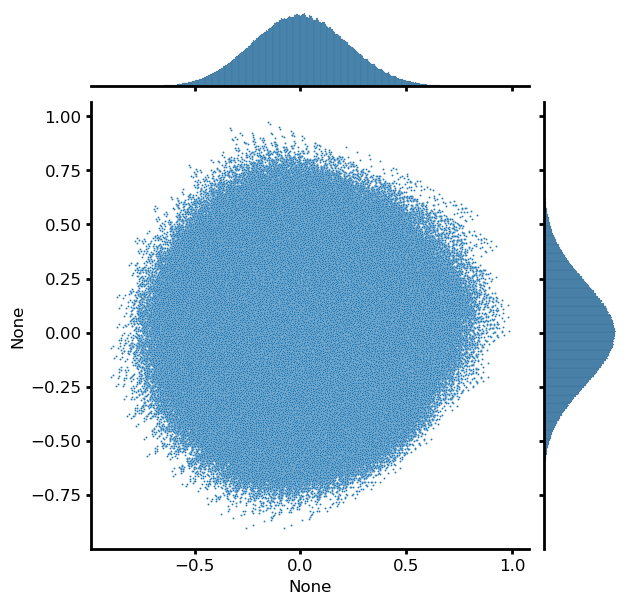

In [8]:
#plot the embeddings
plt.figure(figsize=(12, 8))
#fitness = fitness_df['fit'].values
#reorder the embeddings so they are based on fitness
#indices = np.argsort(fitness)
#sorted_fitness = fitness[indices]
indices = torch.load('/disk1/jyang4/repos/DKBO-MLDE/results/production/round1/DNN_ENSEMBLE-DO-0-RBF-UCB-[30, 1]_1indices.pt')
sns.jointplot(x=pca_embeddings[:, 0], y=pca_embeddings[:, 1],s = 2)
sns.jointplot(x=pca_embeddings[indices[:-96], 0], y=pca_embeddings[indices[:-96], 1],s = 2)
sns.jointplot(x=pca_embeddings[indices[-96:], 0], y=pca_embeddings[indices[-96:], 1],s = 2)
#plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=sorted_fitness, cmap='viridis', s=5)

TS proposes more diverse samples compared to UCB, especially for the GP. For DKL, the model is less pronounced

In [35]:
data = torch.load('/home/jyang4/repos/DKBO-MLDE/results/archived/trpB_onehot/DKL-DO-0-RBF-TS-[10, 10]_6indices.pt')
data.shape

torch.Size([480])

(array([ 77., 109., 158., 226., 171., 155.,  65.,  27.,   8.,   4.]),
 array([0.04903082, 0.14412774, 0.23922465, 0.33432157, 0.42941849,
        0.52451541, 0.61961233, 0.71470925, 0.80980616, 0.90490308,
        1.        ]),
 <BarContainer object of 10 artists>)

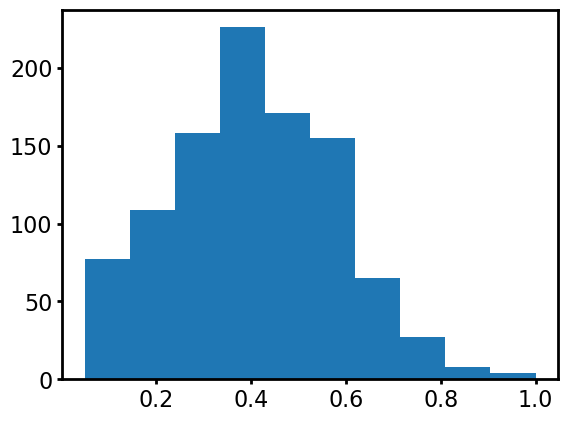

In [142]:
data = pd.read_csv('/home/jyang4/repos/data/TrpB_fitness.csv')
#randomly select 96 rows
maxes = []
for i in range(1000):
    indices = np.random.choice(data.shape[0], 96, replace=False)
    maxes.append(data['fitness'][indices].max())
plt.hist(maxes)

### Analyze the mean and uncertainty values

Maybe should only look at a subset of the values?

### Only look at the ones within 1 to 2 mutations of measured sequences

### See how close the next batch of points are in hamming distance to things that were previously sampled

In [2]:
# plt.figure(figsize=(16, 6))
# #through 10 are the third round
# #after 10 are the models from the first round
# for i in range(10):
#     # indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
#     indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')

#     #subset = fitness_df.iloc[indices[:96]]
#     subset = fitness_df.iloc[indices[:288]]
#     subset
    
#     old_combos = subset['Combo']
#     #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
#     new_combos = fitness_df.iloc[indices[288:384]]['Combo']
#     min_distances = []
#     min_distances_args = []
#     for combo1 in new_combos:
#         distances = []
#         for combo2 in old_combos:
#             distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
#         min_distances.append(min(distances))
#         min_distances_args.append(np.argmin(distances))
    
#     unique_indces, counts = np.unique(min_distances_args, return_counts=True)
#     new_subset = subset.iloc[unique_indces]
#     new_subset['count'] = counts

#     # histogram of the minimum distances
#     # plt.subplot(2, 5, i+1)
#     # plt.hist(min_distances)

#     nearby_variants = []
#     for combo in subset['Combo']:
#         for site in range(4):
#             for aa in ALL_AAS:
#                 variant = combo[:site] + aa + combo[site+1:]
#                 nearby_variants.append(variant)
#     #drop duplicates in nearby_variants
#     nearby_variants = list(set(nearby_variants))

#     nearby_df = fitness_df[fitness_df['Combo'].isin(nearby_variants)]
#     nearby_indices = nearby_df.index

#     #len(nearby_variants)

# plt.tight_layout()

In [20]:
subset.sort_values('fit', ascending=False)

,Combo,muts,fit,zs score,num_muts,AA1,AA2,AA3,AA4
134973,WWFV,V39W:D40W:G41F,0.716157,129.04122,3,W,W,F,V
120359,WRFV,V39W:D40R:G41F,0.638370,118.22869,3,W,R,F,V
97671,WSFV,V39W:D40S:G41F,0.601167,127.38948,3,W,S,F,V
22915,TYGM,V39T:D40Y:V54M,0.598350,155.76928,3,T,Y,G,M
6600,LYGV,V39L:D40Y,0.579242,165.03216,2,L,Y,G,V
...,...,...,...,...,...,...,...,...,...
27772,AQFY,V39A:D40Q:G41F:V54Y,0.000000,138.10131,4,A,Q,F,Y
89606,DHAF,V39D:D40H:G41A:V54F,0.000000,147.48784,4,D,H,A,F
92093,THAN,V39T:D40H:G41A:V54N,0.000000,151.40005,4,T,H,A,N
89194,LWQQ,V39L:D40W:G41Q:V54Q,0.000000,138.38524,4,L,W,Q,Q


In [21]:
#count tells you how many times this was the closest mutant in the top 96
new_subset.sort_values('fit', ascending=False)

,Combo,muts,fit,zs score,num_muts,AA1,AA2,AA3,AA4,count
134973,WWFV,V39W:D40W:G41F,0.716157,129.04122,3,W,W,F,V,9
97671,WSFV,V39W:D40S:G41F,0.601167,127.38948,3,W,S,F,V,1
22915,TYGM,V39T:D40Y:V54M,0.598350,155.76928,3,T,Y,G,M,5
6600,LYGV,V39L:D40Y,0.579242,165.03216,2,L,Y,G,V,10
103072,WVFV,V39W:D40V:G41F,0.565280,124.88220,3,W,V,F,V,1
99020,WIFV,V39W:D40I:G41F,0.562328,127.25167,3,W,I,F,V,2
28746,WAFV,V39W:D40A:G41F,0.557065,126.61346,3,W,A,F,V,1
46375,WKFV,V39W:D40K:G41F,0.512493,124.36001,3,W,K,F,V,1
70642,WKFG,V39W:D40K:G41F:V54G,0.508239,136.72311,4,W,K,F,G,4
2351,IYGV,V39I:D40Y,0.500772,166.74903,2,I,Y,G,V,5


In [4]:
subset['fit'].max()

0.6260269025642482

In [ ]:
#file names here
if model == 'DKL':
            if encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}indices.pt')
            elif encoding == 'onehot':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')
            elif encoding == 'georgiev':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-dropout':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0.1-RBF-UCB-[30, 30]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0.1-RBF-UCB-[30, 30]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0.1-RBF-UCB-[30, 30]_{str(i+1)}indices.pt')
            elif encoding == 'ESM2':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/DKL_BOTORCH-DO-0-RBF-UCB-[50, 50]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/DKL_BOTORCH-DO-0-RBF-UCB-[50, 50]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/DKL_BOTORCH-DO-0-RBF-UCB-[50, 50]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-oneround':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-oneround-DO-0-RBF-UCB-[10, 10]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-oneround-DO-0-RBF-UCB-[10, 10]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/DKL_BOTORCH-oneround-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-long':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[10, 10]_{str(i+1)}indices.pt')
        elif model == 'CDKL':
            if encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/CDKL_BOTORCH-DO-0-RBF-UCB-[16, 16]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/CDKL_BOTORCH-DO-0-RBF-UCB-[16, 16]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/CDKL_BOTORCH-DO-0-RBF-UCB-[16, 16]_{str(i+1)}indices.pt')
        elif model == 'GP':
            if encoding == 'georgiev':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}indices.pt')
            elif encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}indices.pt')
            elif encoding == 'onehot':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
            elif encoding == 'ESM2':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/GP_BOTORCH-DO-0-RBF-UCB-[5120, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/GP_BOTORCH-DO-0-RBF-UCB-[5120, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_ESM2/GP_BOTORCH-DO-0-RBF-UCB-[5120, 1]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-oneround':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
            elif encoding == 'onehot-long':
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
if model == 'DKL':
            if encoding == 'onehot':
                #simga and mu are from the last model thats trained
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_{str(i+1)}indices.pt')
            elif encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_{str(i+1)}indices.pt')
        
         elif model == 'GP':
            if encoding == 'onehot':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_{str(i+1)}indices.pt')
            elif encoding == 'AA':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_{str(i+1)}indices.pt')
            elif encoding == 'georgiev':
                sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}sigma.pt')
                mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}mu.pt')
                indices = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/TrpB_georgiev/GP_BOTORCH-DO-0-RBF-UCB-[76, 1]_{str(i+1)}indices.pt')

### Do it all here

0.5420319363535245
0.3553092145366338
0.3594316560777734
0.48165324987902897
0.4655091152461211
0.49067109075027177
0.38049004266978365
0.5739557214586908
0.32373734517278435
0.48177264986269003


Text(0, 0.5, 'Empirical confidence')

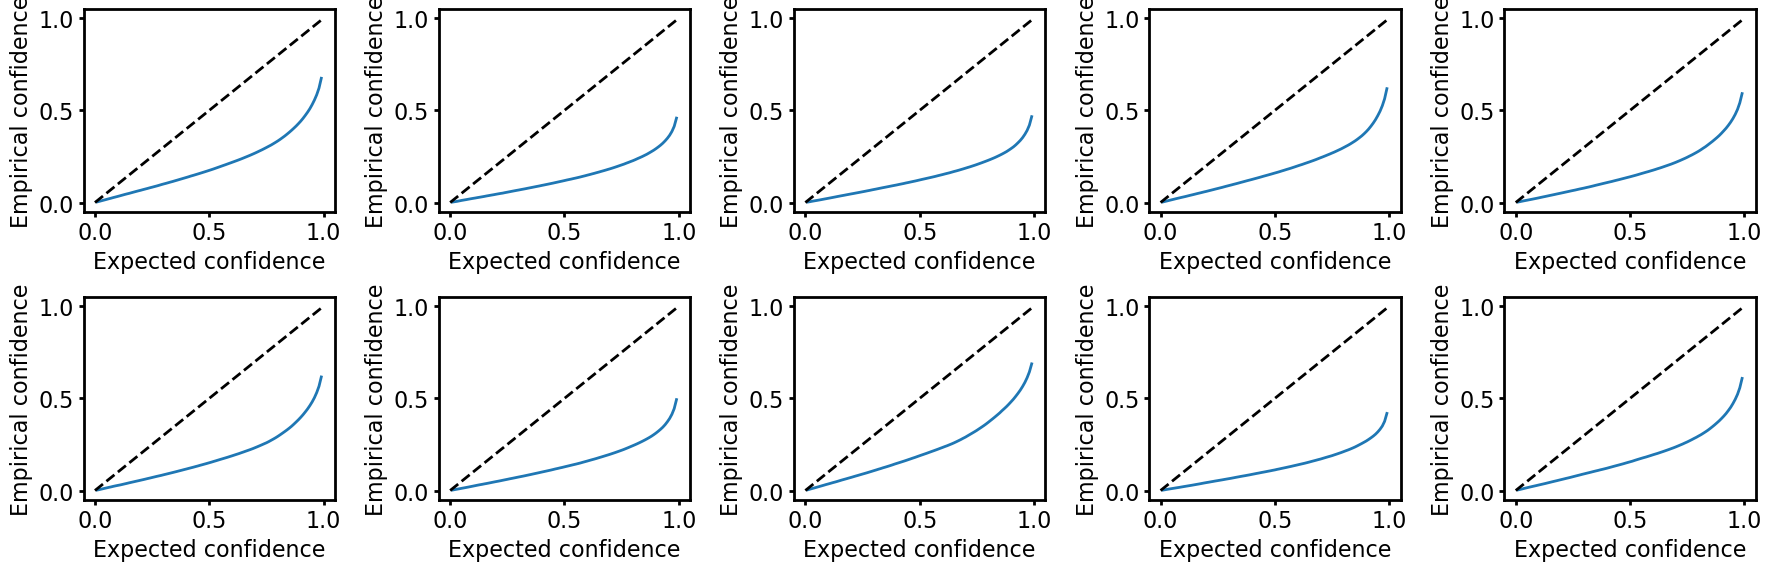

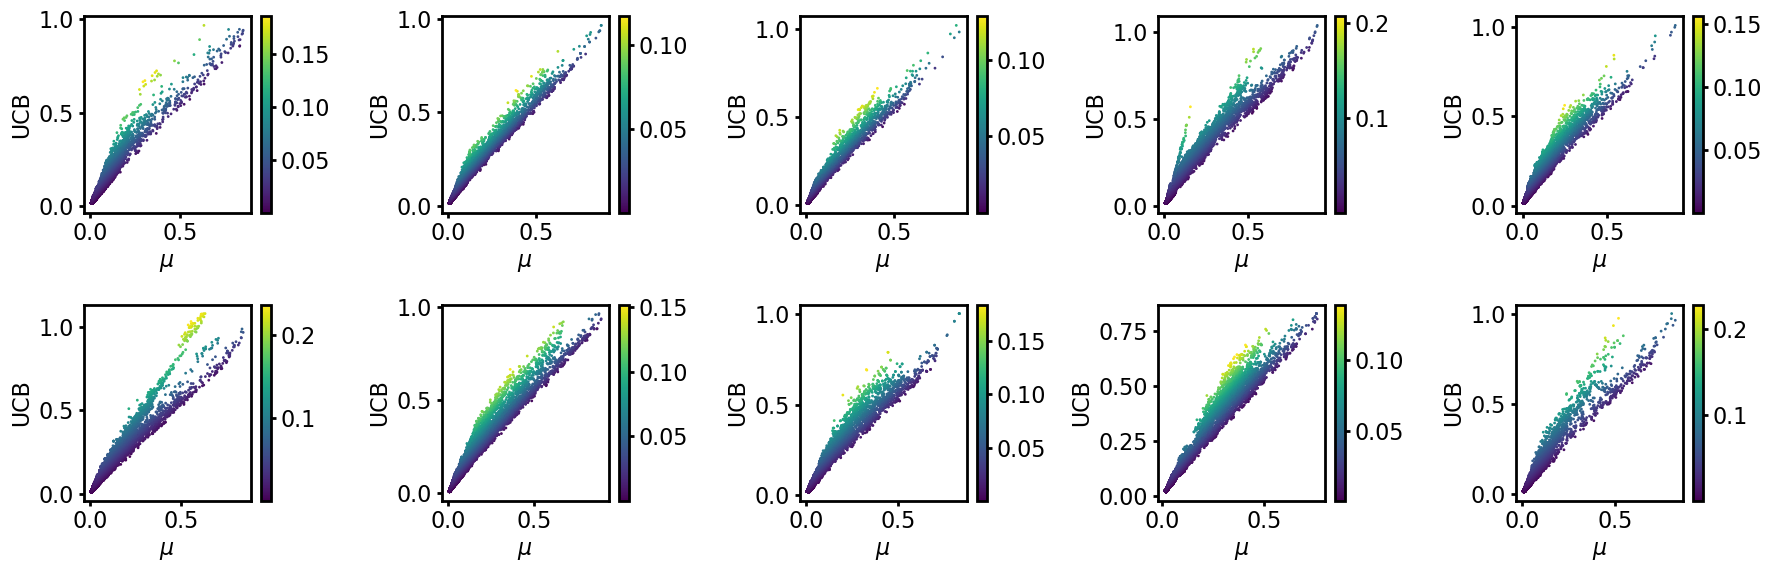

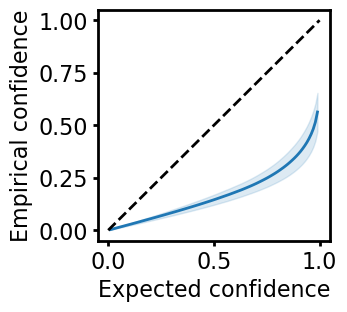

In [17]:
plt.figure(1, figsize=(18, 6))
plt.figure(2, figsize=(18, 6))


protein = 'TrpB'
encoding = 'AA'
#model = 'GP'
#directory_prefix = '/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_onehot/GP_BOTORCH-DO-0-RBF-UCB-[80, 1]_'
#directory_prefix = '/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/MLDE-UCB_'
#directory_prefix = '/disk1/jyang4/repos/DKBO-MLDE/results/TrpB_AA/DNN-ES_ENSEMBLE-DO-0-RBF-UCB-[8, 1]_'
directory_prefix = '/disk1/jyang4/repos/DKBO-MLDE/results/TrpB_AA/BOOSTING_ENSEMBLE-DO-0-RBF-UCB-[16, 1]_'
#directory_prefix = '/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/GB1_AA/GP_BOTORCH-DO-0-RBF-UCB-[16, 1]_'
#directory_prefix = '/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/hyperparameters/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_'
#directory_prefix = '/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/hyperparameters_earlystopping2/GB1_onehot/DKL_BOTORCH-DO-0-RBF-UCB-[30, 30]_'
# directory_prefix = '/home/jyang4/repos/DKBO-MLDE/results/UQ_analysis/hyperparameters_earlystopping2/GB1_AA/DKL_BOTORCH-DO-0-RBF-UCB-[4, 4]_'

n_repeats =10
all_ys = np.zeros((99, n_repeats))
for i in range(n_repeats):

    # mu = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}mu.pt')
    # sigma = torch.load(f'/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/GP_BOTORCH-oneround-DO-0-RBF-UCB-[80, 1]_{str(i+1)}sigma.pt')

    if protein == 'GB1':
        fitness_df = pd.read_csv('/disk1/jyang4/repos/data/GB1_fitness.csv')
        fitness_col = 'fit'
    elif protein == 'TrpB':
         fitness_df = pd.read_csv('/disk1/jyang4/repos/data/TrpB_fitness.csv')
         fitness_col = 'fitness'
    
    sigma = torch.load(directory_prefix + str(i+1) + 'sigma.pt')
    mu = torch.load(directory_prefix + str(i+1) + 'mu.pt')
    indices = torch.load(directory_prefix + str(i+1) + 'indices.pt')
   

    fitness_df[fitness_col] = fitness_df[fitness_col]/fitness_df[fitness_col].max()
    fitness_df['sigma'] = sigma
    fitness_df['mu'] = mu
    
    fitness_df['normalized_sigma'] = abs(sigma/mu)
    fitness_df['UCB'] = fitness_df['mu'] + 2 * fitness_df['sigma']
    fitness_df['LCB'] = fitness_df['mu'] - 2 * fitness_df['sigma']
    fitness_df['calibrated'] = (fitness_df[fitness_col] > fitness_df['LCB']) & (fitness_df[fitness_col] < fitness_df['UCB'])
    fitness_df['normalized_error'] = abs((fitness_df['mu'] - fitness_df[fitness_col])/fitness_df['mu'])
    fitness_df['error'] = abs((fitness_df['mu'] - fitness_df[fitness_col]))
    
    print(fitness_df['calibrated'].sum()/len(fitness_df))

    #subset = fitness_df.iloc[indices[:96]]
    subset = fitness_df.iloc[indices[:384]]
    subset
    
    old_combos = subset['Combo']
    #new_combos = fitness_df.iloc[indices[96:192]]['Combo']
    new_combos = fitness_df.iloc[indices[384:]]['Combo']
    min_distances = []
    min_distances_args = []
    for combo1 in new_combos:
        distances = []
        for combo2 in old_combos:
            distances.append(sum([combo1[i] != combo2[i] for i in range(len(combo1))]))
        min_distances.append(min(distances))
        min_distances_args.append(np.argmin(distances))
    
    unique_indces, counts = np.unique(min_distances_args, return_counts=True)
    #new_subset = subset.iloc[unique_indces]
    #new_subset['count'] = counts

    # histogram of the minimum distances
    # plt.subplot(2, 5, i+1)
    # plt.hist(min_distances)

    nearby_variants = []
    #for combo in subset['Combo']:
    ordered_subset = subset.sort_values(fitness_col, ascending=False)
    for combo in ordered_subset['Combo'][:]:
        for site in range(4):
            for aa in ALL_AAS:
                variant = combo[:site] + aa + combo[site+1:]
                nearby_variants.append(variant)
    #drop duplicates in nearby_variants
    nearby_variants = list(set(nearby_variants))
    #print(len(nearby_variants))

    #to filter to only nearby variants
    nearby_df = fitness_df[fitness_df['Combo'].isin(nearby_variants)]
    nearby_indices = nearby_df.index
    #print(nearby_df['calibrated'].sum()/len(nearby_df))

    top_nearby_df = nearby_df.sort_values(fitness_col, ascending=False)[:96]
    #print(top_nearby_df['calibrated'].sum()/len(top_nearby_df))
    #print('\n')

    #get rid of outliers
    #print(len(fitness_df))
    
    fitness_df.sort_values(fitness_col, ascending=True, inplace=True)


    # plt.hist(fitness_df['sigma'])
    # plt.title('$\sigma$')
    plt.figure(1)
    plt.subplot(2, 5, i+1)
    confidences = np.linspace(0.01, 0.99, 99)
    y = []
    for confidence in confidences:
        z_score = z_score_for_confidence_interval(confidence)
        #fitness_df = nearby_df only check the similar variants
        #fitness_df = subset
        fitness_df['UCB_temp'] = fitness_df['mu'] + z_score * fitness_df['sigma']
        fitness_df['LCB_temp'] = fitness_df['mu'] - z_score * fitness_df['sigma']
        fitness_df['calibrated_temp'] = (fitness_df[fitness_col] > fitness_df['LCB_temp']) & (fitness_df[fitness_col] < fitness_df['UCB_temp'])
        y.append(fitness_df['calibrated_temp'].sum()/len(fitness_df))
    
    all_ys[:, i] = y
    plt.plot(confidences, y, '-')
    plt.plot([0,1], [0,1], '--k')
    plt.xlabel('Expected confidence')
    plt.ylabel('Empirical confidence')
    plt.tight_layout()

    # plt.scatter(x = fitness_df['sigma'], y =fitness_df['mu'], c=fitness_df[fitness_col], cmap='viridis', vmin=0, vmax=1, s=5)
    # #plt.xlim([0, 3])
    # plt.xlabel('$\sigma$')
    # plt.ylabel('$\mu$')

    plt.figure(2)
    plt.subplot(2, 5, i+1)
    fitness_df.sort_values('sigma', ascending=True, inplace=True)
    sc = plt.scatter(x = fitness_df['mu'], y =fitness_df['UCB'], c=fitness_df['sigma'], cmap='viridis', s=1)
    plt.colorbar(sc)
    # sns.jointplot(x = fitness_df['mu'], y =fitness_df['UCB'])
    plt.xlabel('$\mu$')
    plt.ylabel('UCB')
    plt.tight_layout()

    # plt.scatter(x = fitness_df['sigma'], y =fitness_df['error'], c=fitness_df[fitness_col], cmap='viridis', s=5)
    # plt.title(pearsonr(fitness_df['sigma'], fitness_df['error'])[0].round(2))
    # plt.xlabel('$\sigma$')
    # plt.ylabel('error')

    # fitness_df = fitness_df[fitness_df['normalized_sigma'] < 1]
    # plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['normalized_error'], c=fitness_df[fitness_col], cmap='viridis', s=5)
    # plt.xlim([0, 1])
    # #plt.ylim([0, 10])
    # plt.title(pearsonr(fitness_df['normalized_sigma'], fitness_df['normalized_error'])[0].round(2))
    # plt.xlabel('normalized $\sigma$')
    # plt.ylabel('normalized error')

plt.figure(3, figsize=(3, 3))
mean = all_ys.mean(axis=1)
p = plt.plot(confidences, mean, '-')
sem = all_ys.std(axis=1)
plt.fill_between(confidences, mean - sem, mean + sem, color=p[-1].get_color(), alpha=.15)
plt.plot([0,1], [0,1], '--k')
plt.xlabel('Expected confidence')
plt.ylabel('Empirical confidence')

(array([1.45444e+05, 1.01400e+04, 2.14000e+03, 8.27000e+02, 3.45000e+02,
        1.42000e+02, 5.00000e+01, 2.60000e+01, 9.00000e+00, 6.00000e+00]),
 array([0.00079364, 0.01900488, 0.03721612, 0.05542737, 0.07363861,
        0.09184985, 0.1100611 , 0.12827234, 0.14648359, 0.16469483,
        0.18290607]),
 <BarContainer object of 10 artists>)

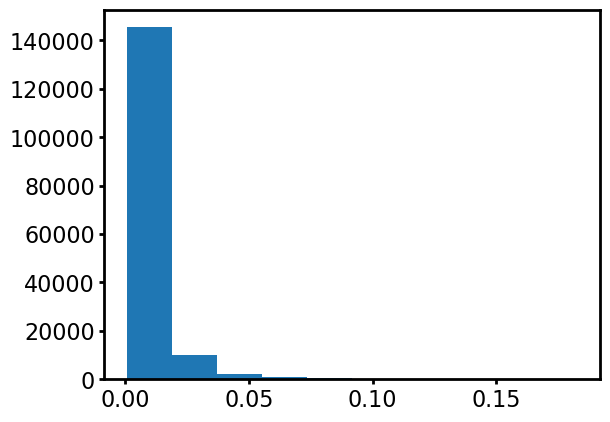

In [38]:
plt.hist(fitness_df['sigma'])

(array([1.54812e+05, 3.06400e+03, 6.74000e+02, 2.51000e+02, 1.19000e+02,
        7.20000e+01, 5.50000e+01, 3.20000e+01, 3.20000e+01, 1.80000e+01]),
 array([0.00658385, 0.08768436, 0.16878486, 0.24988537, 0.33098588,
        0.41208639, 0.49318689, 0.5742874 , 0.65538791, 0.73648842,
        0.81758893]),
 <BarContainer object of 10 artists>)

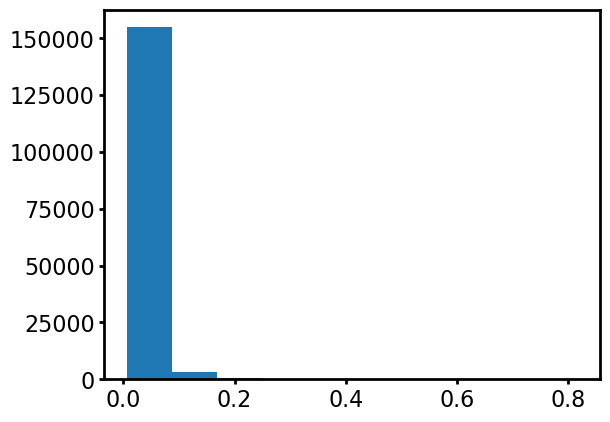

In [39]:
plt.hist(fitness_df['mu'])

### Calibration Curves

### Old plots: see if uncertainty is calibrated with fitness

Is it correlated to error in the model?

Text(0, 0.5, '$\\mu$')

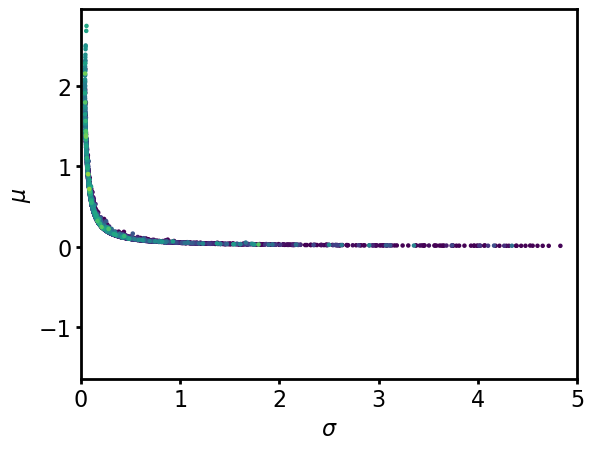

In [17]:
from scipy.stats import pearsonr

fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')

fitness_df['fit'] = fitness_df['fit']/fitness_df['fit'].max()

fitness_df['sigma'] = sigma
fitness_df['mu'] = mu
normalized = sigma/mu
fitness_df['normalized_sigma'] = normalized

fitness_df.sort_values('fit', ascending=True, inplace=True)

#sns.jointplot(fitness_df, x='sigma',  y='mu')
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['mu'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')

Text(0, 0.5, 'UCB')

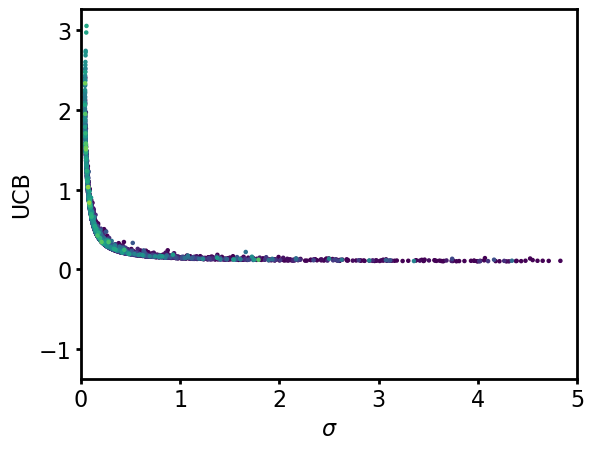

In [18]:
fitness_df['delta'] = fitness_df['mu'] + 2 * fitness_df['sigma']
#fitness_df = fitness_df.sort_values('delta', ascending=False)[:96]

#sns.jointplot(fitness_df, x = 'sigma', y = 'delta', s =2)
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['delta'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('UCB')

Text(0, 0.5, 'UCB')

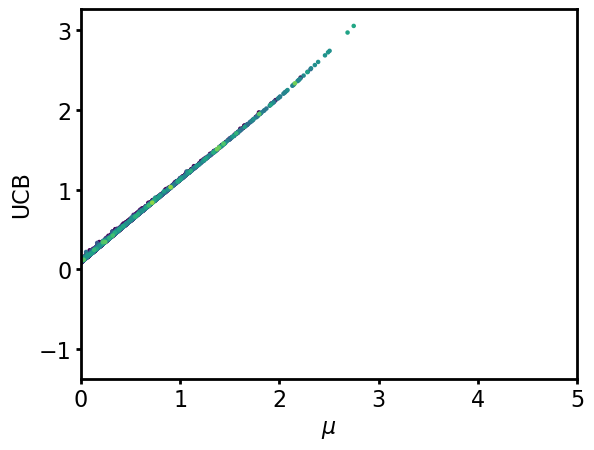

In [19]:
#sns.jointplot(fitness_df, x = 'sigma', y = 'delta', s =2)
plt.scatter(x = fitness_df['mu'], y =fitness_df['delta'], c=fitness_df['fit'], cmap='viridis', vmin=0, vmax=1, s=5)
plt.xlim([0, 5])
plt.xlabel('$\mu$')
plt.ylabel('UCB')

PearsonRResult(statistic=-0.00015449940596186208, pvalue=0.9523871856006372)


Text(0, 0.5, 'error')

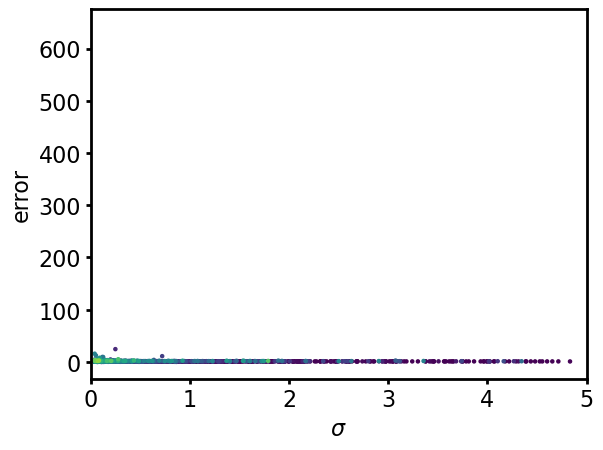

In [20]:
fitness_df['error'] = abs((mu - fitness_df['fit'])/mu)

#fitness_df['error'] = abs((fitness_df['mu'] - fitness_df['fit']))
print(pearsonr(fitness_df['normalized_sigma'], fitness_df['error']))

#sns.jointplot(fitness_df, x = 'sigma', y = 'error', s =2)
plt.scatter(x = fitness_df['normalized_sigma'], y =fitness_df['error'], c=fitness_df['fit'], cmap='viridis', s=5)
plt.xlim([0, 5])
plt.xlabel('$\sigma$')
plt.ylabel('error')

### Analyze whether there is mode collapse

In [24]:
embeddings = torch.load('/home/jyang4/repos/DKBO-MLDE/results/GB1_onehot/embeddings.pt') # onehot, DKL, TS
#embeddings = torch.load('/home/jyang4/repos/data/trpB_onehot_x.pt')
fitness_df = pd.read_csv('/home/jyang4/repos/data/GB1_fitness.csv')
embeddings = embeddings.detach().numpy()
embeddings.shape

(149361, 10)

In [25]:
# check for duplicates, i don't think there should be any
# for row in embeddings:
#     if len(np.where((embeddings == row).all(axis=1))[0]) > 1:
#         print('bad')

<Figure size 1200x800 with 0 Axes>

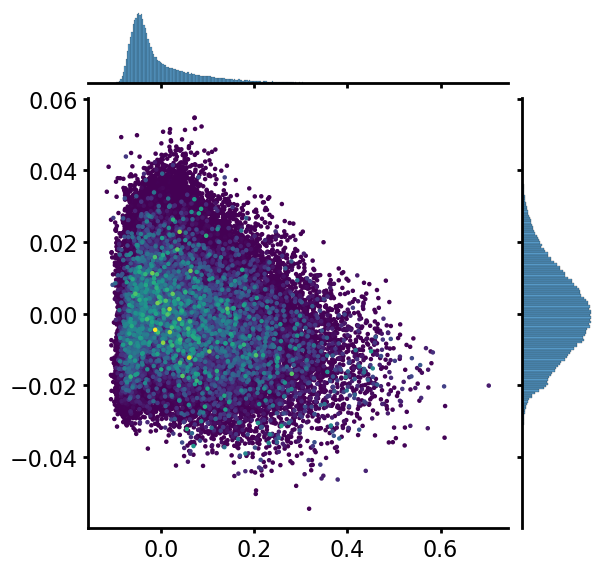

In [26]:
#PCA transform on embeddings
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(embeddings)
pca_embeddings = pca.transform(embeddings)

#plot the embeddings
plt.figure(figsize=(12, 8))
fitness = fitness_df['fit'].values
#reorder the embeddings so they are based on fitness
indices = np.argsort(fitness)
sorted_fitness = fitness[indices]

sns.jointplot(x=pca_embeddings[indices, 0], y=pca_embeddings[indices, 1],s = 2)
plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=sorted_fitness, cmap='viridis', s=5)